In [1]:
from utilities import *

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
dataset = load_dataset("Train")

Loaded 100 subjects


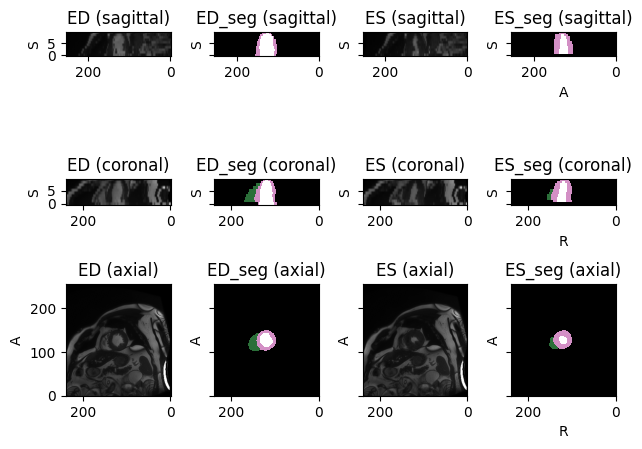

In [3]:
dataset[20].plot()

In [12]:
X,y = create_features_matrix(dataset, category=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1) #random_state=int for reproducibility

In [13]:
clf = RandomForestClassifier().fit(X_train, y_train)
clf.score(X_val, y_val)

0.3

Loaded 50 subjects


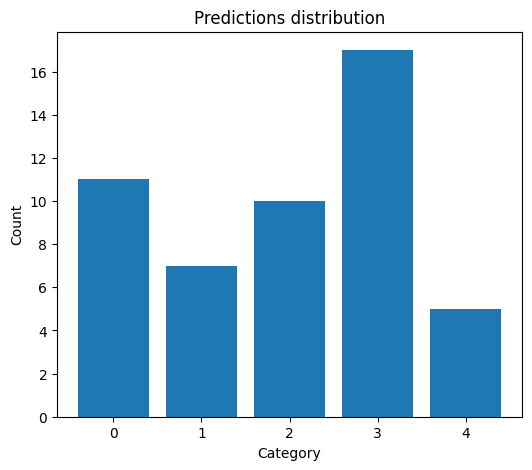

Submission file submission.csv created


In [14]:
submission(clf, "submission")